Article Scraper that gives both Images and Alt-Text

In [ ]:
import csv
import pandas as pd
import re
import requests
from bs4 import BeautifulSoup
import time

def img_selector(tag):
    return (
        tag.name == "img" and tag.has_attr("class") and "post-content__thumbnail--image" in tag.get("class") or
        tag.name == "img" and tag.has_attr("class") and any(re.match(r"^wp-image", class_name) for class_name in tag.get("class"))
    )

def getImages(soup):
    imagesSearch = soup.find_all(img_selector)
    imagesSearch = [img['src'] for img in imagesSearch if img.has_attr('src')]
    return imagesSearch

def getAltText(soup):
    altTextSearch = soup.find_all(img_selector)
    altTextSearch = [img['alt'] for img in altTextSearch if img.has_attr('alt')]
    return altTextSearch

# Load the CSV without headers
file_path = "/content/Trained_newsroom_dataset.csv"
df = pd.read_csv(file_path, usecols=[1])  # header=None treats the first row as data

# Assign a default column name
df.columns = ["links"]

# Create empty lists to store the image URLs and alt text
image_urls = []
alt_texts = []

counter = 1

for index, value in df.iterrows():
    # URL of the Purdue newsroom page
    url = value['links']

    # Fetch the webpage content
    response = requests.get(url)

    print(f"Article Number: {counter}")
    counter += 1

    if response.status_code == 200:
        soup = BeautifulSoup(response.content, "html.parser")

        # Get images and alt text
        images = getImages(soup)
        altText = getAltText(soup)

        print(f"Found {len(images)} images:")
        for i, image_url in enumerate(images, 1):
            image_urls.append(image_url)  # Add the image URL to the list
            print(f"{i}. {image_url}")

        print(f"Found {len(altText)} alt texts:")
        for i, image_alt in enumerate(altText, 1):
            alt_texts.append(image_alt)  # Add the alt text to the list
            print(f"{i}. {image_alt}")
    else:
        print(f"Failed to fetch the page. Status code: {response.status_code}")

    time.sleep(5)

# Create DataFrame for images and alt text
df_images = pd.DataFrame(image_urls, columns=["Image_URL"])
df_alt_texts = pd.DataFrame(alt_texts, columns=["Alt_Text"])

# Optionally, save these DataFrames to CSV files
df_images.to_csv("/content/drive/MyDrive/image_urls.csv", index=False)
df_alt_texts.to_csv("/content/drive/MyDrive/alt_texts.csv", index=False)

# Display the DataFrames
print("DataFrame for Image URLs:")
print(df_images.head())

print("DataFrame for Alt Texts:")
print(df_alt_texts.head())


Blip Model

dict_keys(['pixel_values', 'input_ids', 'attention_mask'])


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


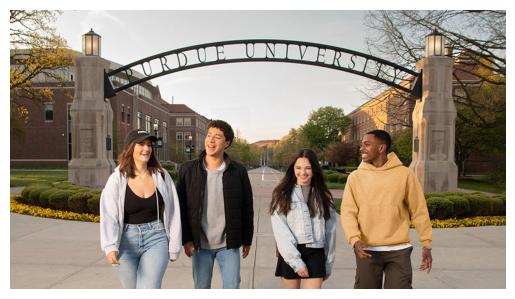

Original Caption: Four smiling college students walking on Purdue University's campus under the Gateway to the Future arch.
Generated Caption: group of people walking on a sidewalk


Epoch 1/5:  10%|▉         | 10/105 [00:30<04:52,  3.07s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 1/5: 100%|██████████| 105/105 [05:31<00:00,  3.15s/it]


Epoch 1 - Loss: 3.4956057188056766


Epoch 2/5:  97%|█████████▋| 102/105 [05:15<00:08,  2.89s/it]

Retry 1/5 failed: HTTPSConnectionPool(host='www.purdue.edu', port=443): Read timed out. (read timeout=10)


Epoch 2/5: 100%|██████████| 105/105 [05:35<00:00,  3.20s/it]


Epoch 2 - Loss: 0.10694004478199141


Epoch 3/5:  34%|███▍      | 36/105 [01:51<03:46,  3.28s/it]

Retry 1/5 failed: HTTPSConnectionPool(host='www.purdue.edu', port=443): Read timed out. (read timeout=10)


Epoch 3/5:  48%|████▊     | 50/105 [02:47<02:49,  3.08s/it]

Retry 1/5 failed: HTTPSConnectionPool(host='www.purdue.edu', port=443): Read timed out. (read timeout=10)


Epoch 3/5: 100%|██████████| 105/105 [05:48<00:00,  3.32s/it]


Epoch 3 - Loss: 0.05241768867486999


Epoch 4/5:  50%|█████     | 53/105 [02:44<02:49,  3.26s/it]

Retry 1/5 failed: HTTPSConnectionPool(host='www.purdue.edu', port=443): Read timed out. (read timeout=10)


Epoch 4/5: 100%|██████████| 105/105 [05:34<00:00,  3.19s/it]


Epoch 4 - Loss: 0.03036980495921203


Epoch 5/5:  42%|████▏     | 44/105 [02:15<03:03,  3.01s/it]

Retry 1/5 failed: HTTPSConnectionPool(host='www.purdue.edu', port=443): Read timed out. (read timeout=10)


Epoch 5/5:  71%|███████▏  | 75/105 [04:04<01:31,  3.03s/it]

Retry 1/5 failed: HTTPSConnectionPool(host='www.purdue.edu', port=443): Read timed out. (read timeout=10)


Epoch 5/5: 100%|██████████| 105/105 [05:45<00:00,  3.29s/it]


Epoch 5 - Loss: 0.01926048385600249


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Original Caption: Four smiling college students walking on Purdue University's campus under the Gateway to the Future arch.
Generated Caption: four smiling college students walking on purdue university ' s campus under the gateway to the future arch.


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BlipProcessor, BlipForConditionalGeneration
from transformers import AdamW
from PIL import Image
import requests
import os
from tqdm import tqdm
import pandas as pd
from io import BytesIO
import time
from requests.exceptions import ConnectionError, Timeout, RequestException

# Load the pretrained BLIP model and processor
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

class ImageCaptionDataset(Dataset):
    def __init__(self, image_paths, captions, processor, max_retries=3, retry_delay=2):
        self.image_paths = image_paths
        self.captions = captions
        self.processor = processor
        self.max_retries = max_retries
        self.retry_delay = retry_delay

    def __len__(self):[=]
        return len(self.image_paths)

    def fetch_image_with_retries(self, url):
        """Fetch image with retry mechanism."""
        for attempt in range(self.max_retries):
            try:
                response = requests.get(url, stream=True, timeout=10)
                if response.status_code == 200:
                    return Image.open(response.raw).convert("RGB")
                else:
                    raise ValueError(f"HTTP error {response.status_code}")
            except (ConnectionError, Timeout) as e:
                print(f"Retry {attempt + 1}/{self.max_retries} failed: {e}")
                if attempt < self.max_retries - 1:
                    time.sleep(self.retry_delay)  # Wait before retrying
                else:
                    raise ValueError(f"Failed to fetch image after {self.max_retries} attempts: {url}")
            except RequestException as e:
                raise ValueError(f"Request failed: {e}")

    def __getitem__(self, idx):
        # Load image_url and alt-text
        image_path = self.image_paths[idx]
        caption = self.captions[idx]

        # Make sure Alt-Text is string
        if not isinstance(caption, str):
            caption = str(caption) if caption is not None else ""

        # Handle URLs or local image paths
        if image_path.startswith("http"):
            image = self.fetch_image_with_retries(image_path)
        else:
            try:
                image = Image.open(image_path).convert("RGB")
            except Exception as e:
                raise ValueError(f"Failed to open local image: {image_path}. Error: {e}")

        # Preprocess the image and caption
        inputs = self.processor(
            images=image,
            text=caption,
            return_tensors="pt",
            padding="max_length",
            truncation=True,
        )

        return {
            "pixel_values": inputs["pixel_values"].squeeze(0),
            "input_ids": inputs["input_ids"].squeeze(0),
            "attention_mask": inputs["attention_mask"].squeeze(0),
        }

csv_file_path = "/content/ImageAndText.csv"
df = pd.read_csv(csv_file_path)

# Extract image_URLs and Alt-Texts from the CSV
image_paths = df['Image_URL'].tolist()
captions = df['Alt_Text'].tolist()

# Create dataset and dataloader
dataset = ImageCaptionDataset(image_paths=image_paths, captions=captions, processor=processor, max_retries=5)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Check if proper dataset
for batch in dataloader:
    print(batch.keys())
    break

# Adam Optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# Using untrained
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('/content/testImage.jpeg')
plt.imshow(img)
plt.axis('off')
plt.show()
caption = processor.decode(out[0], skip_special_tokens=True)
print(f"Original Caption: Four smiling college students walking on Purdue University's campus under the Gateway to the Future arch.")
print(f"Generated Caption: {caption}")

# Training loop
epochs = 5
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
        batch = {k: v.to(device) for k, v in batch.items()}

        # Forward pass
        outputs = model(
            pixel_values=batch["pixel_values"],
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
            labels=batch["input_ids"]
        )

        # Compute loss
        loss = outputs.loss
        total_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    print(f"Epoch {epoch+1} - Loss: {total_loss / len(dataloader)}")

# Save the fine-tuned model
model.save_pretrained("fine_tuned_blip_model")

# Model Evaluation on testImage
model.eval()
test_image = Image.open("/content/testImage.jpeg").convert("RGB")
inputs = processor(test_image, return_tensors="pt").to(device)
out = model.generate(**inputs)
caption = processor.decode(out[0], skip_special_tokens=True)
print(f"Original Caption: Four smiling college students walking on Purdue University's campus under the Gateway to the Future arch.")
print(f"Generated Caption: {caption}")
